In [980]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from pprint import pprint

In [527]:
df = pd.read_csv('updated_diamonds.csv')

## EDA

In [528]:
df.drop('Unnamed: 0',axis =1, inplace=True) #removing column that was basically the same as the index
df.drop_duplicates(inplace = True) #might be some duplicate rows based on the way the data was scraped (changing floor price)

In [529]:
df.info() #data types are as expected

<class 'pandas.core.frame.DataFrame'>
Int64Index: 52461 entries, 0 to 52885
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   shape             52461 non-null  object 
 1   original_price    52461 non-null  int64  
 2   discounted_price  6796 non-null   float64
 3   carat             52461 non-null  float64
 4   cut               52461 non-null  object 
 5   color             52461 non-null  object 
 6   clarity           52461 non-null  object 
 7   polish            52461 non-null  object 
 8   symmetry          52461 non-null  object 
 9   fluorescence      52461 non-null  object 
 10  depth             52461 non-null  float64
 11  table             52461 non-null  float64
 12  lxwratio          52461 non-null  float64
 13  culet             52461 non-null  object 
dtypes: float64(5), int64(1), object(8)
memory usage: 6.0+ MB


In [530]:
df.describe()

,original_price,discounted_price,carat,depth,table,lxwratio
count,5.246100e+04,6796.000000,52461.000000,52461.000000,52461.000000,52461.000000
mean,7.941095e+03,2758.761919,0.993874,66.088462,62.946719,1.308527
std,2.688281e+04,11111.163456,0.909858,4.517800,5.039816,0.236147
min,2.210000e+02,238.000000,0.230000,51.000000,51.000000,0.790000
25%,7.930000e+02,453.000000,0.400000,62.700000,59.000000,1.050000
50%,2.152000e+03,851.000000,0.710000,66.200000,62.000000,1.350000
75%,6.409000e+03,1817.000000,1.200000,68.900000,66.000000,1.440000
max,2.702260e+06,343853.000000,20.450000,80.000000,85.000000,3.370000


In [531]:
#Astor Ideal and showing up as ealAstor - need to update
df['cut'] = df['cut'].replace('ealAstor','Astor Ideal')

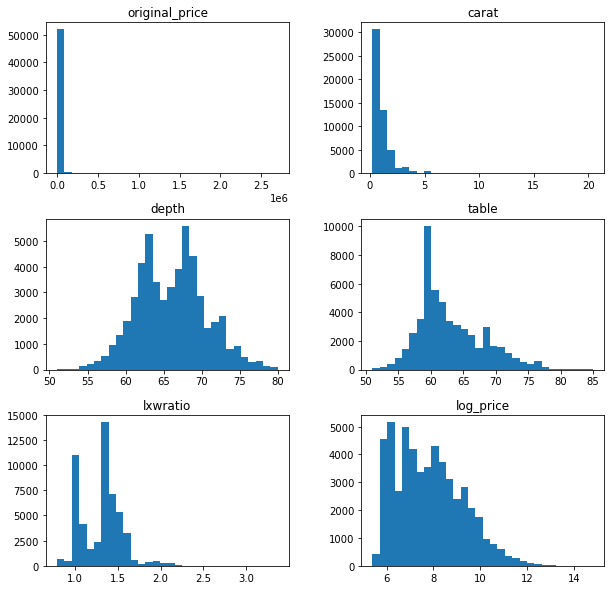

In [560]:
df['log_price'] = np.log(df['original_price'])
df.hist(figsize=(10,10),bins=30,grid=False);

In [534]:
df.corr()

,original_price,discounted_price,carat,depth,table,lxwratio
original_price,1.000000,0.996543,0.750451,-0.001705,0.009492,-0.022267
discounted_price,0.996543,1.000000,0.821921,0.021983,0.024054,-0.041886
carat,0.750451,0.821921,1.000000,0.050836,0.015941,-0.111207
depth,-0.001705,0.021983,0.050836,1.000000,0.592803,-0.555673
table,0.009492,0.024054,0.015941,0.592803,1.000000,-0.446653
lxwratio,-0.022267,-0.041886,-0.111207,-0.555673,-0.446653,1.000000


need to remove discounted price since we are trying to predict original price or else there might be data leakage - model will have the information you are trying to predict

In [535]:
df.drop('discounted_price',axis =1,inplace = True)

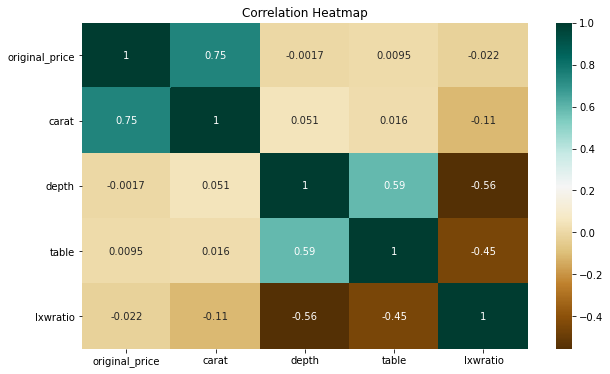

In [536]:
plt.figure(figsize=(10,6))
heatmap = sns.heatmap(df.corr(),cmap = 'BrBG',annot = True)
heatmap.set_title('Correlation Heatmap');

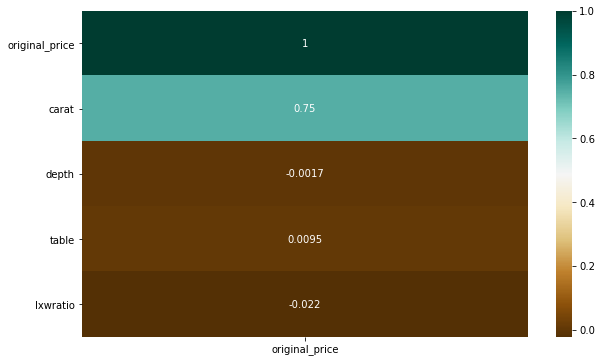

In [537]:
plt.figure(figsize = (10,6))
sns.heatmap(df.corr()[['original_price']],cmap = 'BrBG',annot=True);

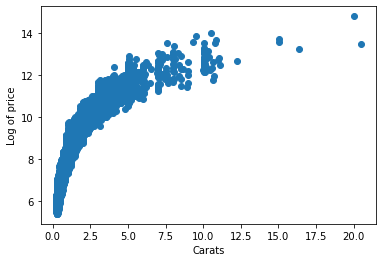

In [561]:
fig,ax = plt.subplots()
ax.scatter(df.carat,np.log(df.original_price))
ax.set_xlabel('Carats')
ax.set_ylabel('Log of price');

Get a sense of categorical features with respect to target

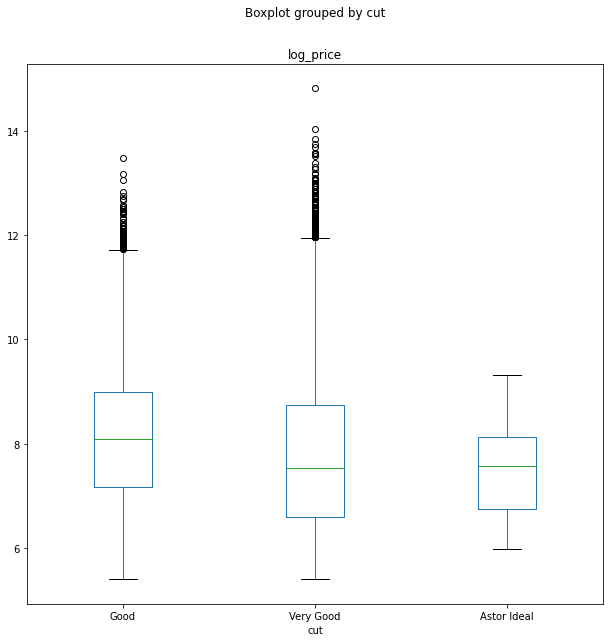

In [559]:
boxplot = df.boxplot(column=['log_price'],by='cut', figsize = (10,10), positions = [2,0,1] ,grid=False)

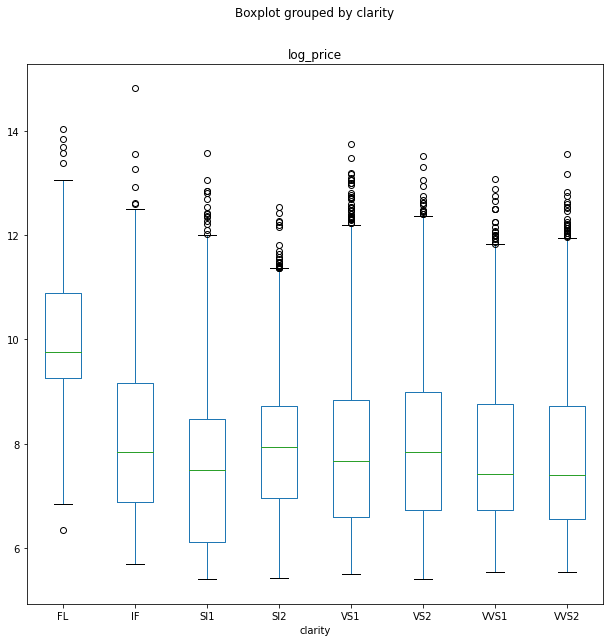

In [539]:
df['log_price'] = np.log(df['original_price'])
boxplot = df.boxplot(column=['log_price'],by='clarity', figsize = (10,10), grid=False)

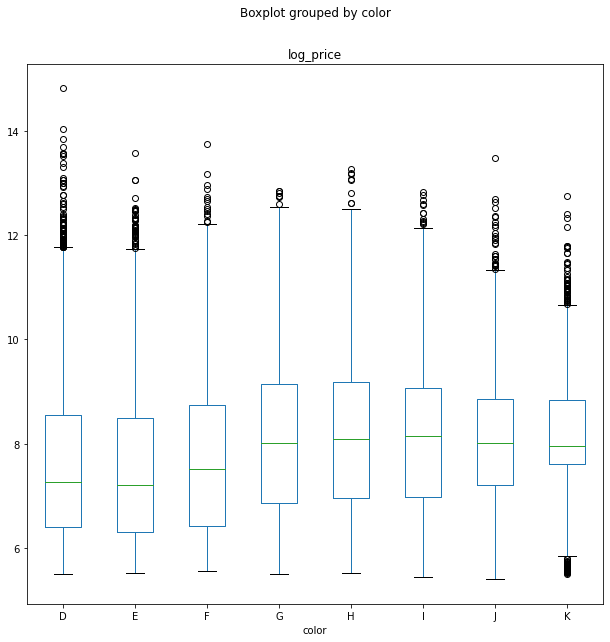

In [540]:
boxplot = df.boxplot(column=['log_price'],by='color', figsize = (10,10), grid=False)

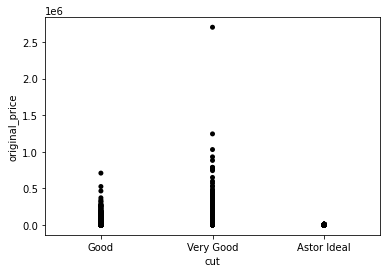

In [541]:
sns.stripplot(data = df,
              x='cut', y='original_price', 
              order = ['Good','Very Good','Astor Ideal'],
              color = 'black', jitter=False);

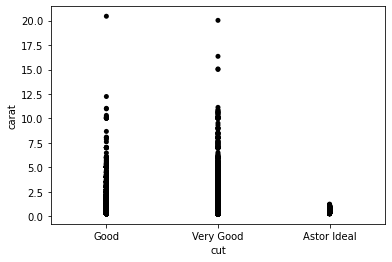

In [542]:
sns.stripplot(data = df,
              x='cut', y='carat', 
              order = ['Good','Very Good','Astor Ideal'],
              color = 'black', jitter=False);

In [543]:
len(df[df.cut == 'Astor Ideal']['cut'])/df.shape[0] #less than one percent of diamonds are astor ideal

0.009759630963954175

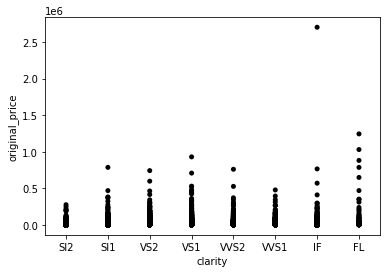

In [544]:
sns.stripplot(data = df,
              x='clarity', y='original_price', 
              order = ['SI2','SI1','VS2','VS1','VVS2','VVS1','IF','FL'],
              color = 'black', jitter=False);

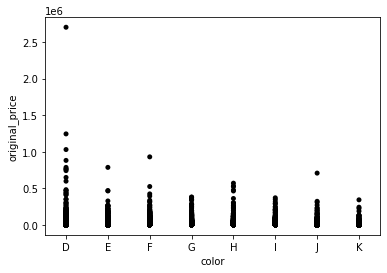

In [545]:
sns.stripplot(data = df,
              x='color', y='original_price', 
              order = ['D', 'E','F','G','H','I','J','K'],
              color = 'black', jitter=False);

## Linear Regression Model

dummyize categorical features

In [914]:
linreg = LinearRegression()

X = df.drop(['original_price','log_price'],axis = 1)
y = df.original_price
X_train, X_test, y_train, y_test = train_test_split(X,y)

In [966]:
X_train_1 = pd.get_dummies(X_train)
X_test_1 = pd.get_dummies(X_test)
y_predicted_1 = linreg.fit(X_train_1,y_train).predict(X_test_1)
print(f'Train RMSE: {-cross_val_score(linreg,X_train_1,y_train,scoring="neg_root_mean_squared_error").mean()}')
print(f'Test RMSE: {np.sqrt(mean_squared_error(y_test,y_predicted_1))}')

Train RMSE: 13991.772864505207
Test RMSE: 22757.429589645195


In [967]:
X_train_2 = X_train[['carat','cut','clarity', 'color']]
X_train_2 = pd.get_dummies(X_train_2)
X_test_2 = X_test[['carat','cut','clarity', 'color']]
X_test_2 = pd.get_dummies(X_test_2)
y_predicted_2 = linreg.fit(X_train_2,y_train).predict(X_test_2)
print(f'Train RMSE: {-cross_val_score(linreg,X_train_2,y_train,scoring="neg_root_mean_squared_error").mean()}')
print(f'Test RMSE: {np.sqrt(mean_squared_error(y_test,y_predicted_2))}')

Train RMSE: 14397.16472597673
Test RMSE: 23182.84927866591


The plot below exhibits “heteroscedasticity,” meaning that the residuals get larger as the prediction moves from small to large (or from large to small).

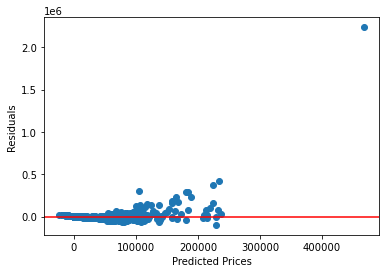

In [946]:
predicted = linreg.fit(X_train_1,y_train).predict(X_test_1)
residuals = y_test - predicted

fig,ax = plt.subplots()
ax.scatter(predicted,residuals)
plt.axhline(y=0, color = 'r')
ax.set_xlabel('Predicted Prices')
ax.set_ylabel('Residuals');

In [924]:
scaler = StandardScaler()
scaler.fit(X_train_1)
X_train_s = scaler.transform(X_train_1)
linreg.fit(X_train_1,y_train)

np.abs(linreg.coef_)

array([23716.36765965,   267.95612346,   251.61249861,  2439.70553589,
        2414.19355204,  2626.28453105,  3036.16493391,   843.40325888,
         182.39458053,  1235.05099849,   649.23323542,  6267.31266428,
        2651.38391263,  4502.32382359,  2815.56992819,  1686.7538954 ,
        5143.27982548,  4526.84373685,  3463.77646424,  1527.95267445,
         201.0825391 ,  2216.1586337 ,  4707.34592484,  7939.43068158,
       44421.37384322,  3824.56345258,  7434.89264521, 10609.63279203,
        5578.87534883,  6969.41234927,  4819.52781258,  5184.46944272,
         522.39791499,    81.5092205 ,   603.90713549,  2409.44645232,
        1404.18529073,  1005.26116159,  3197.14313704,  3477.04802715,
        1550.12664219,   488.64168415,  1004.97975954,  3810.45203897,
        1035.19175553,  1019.68291575,  2578.63014887,  7917.60310059,
         407.77998094,  3041.66756622,   403.29023196,  5286.86234058,
         837.36270239,   720.73892816,  1498.1633567 ])

In [925]:
coefficients = pd.concat([pd.DataFrame(X_train_1.columns, columns = ['features']),pd.DataFrame(np.transpose(np.abs(linreg.coef_)),columns = ['coefs'])], axis = 1)
coefficients.sort_values(by=['coefs'],ascending=False)

,features,coefs
24,clarity_FL,44421.373843
0,carat,23716.367660
27,clarity_SI2,10609.632792
23,color_K,7939.430682
47,fluorescence_Very Strong Blue,7917.603101
26,clarity_SI1,7434.892645
29,clarity_VS2,6969.412349
11,shape_Princess,6267.312664
28,clarity_VS1,5578.875349
51,culet_Pointed,5286.862341


## Random Forest

In [968]:
rf= RandomForestRegressor(n_jobs=-1).fit(X_train_1,y_train)
print(f'Train RMSE: {-cross_val_score(rf,X_train_1,y_train, scoring="neg_root_mean_squared_error").mean()}')
print(f'Test RMSE: {np.sqrt(mean_squared_error(y_test,rf.predict(X_test_1)))}')

Train RMSE: 7289.144366351492
Test RMSE: 18537.17613474698


In [985]:
print('Parameters currently in use:\n')
pprint(rf.get_params())

Parameters currently in use:

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 500,
 'n_jobs': -1,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}


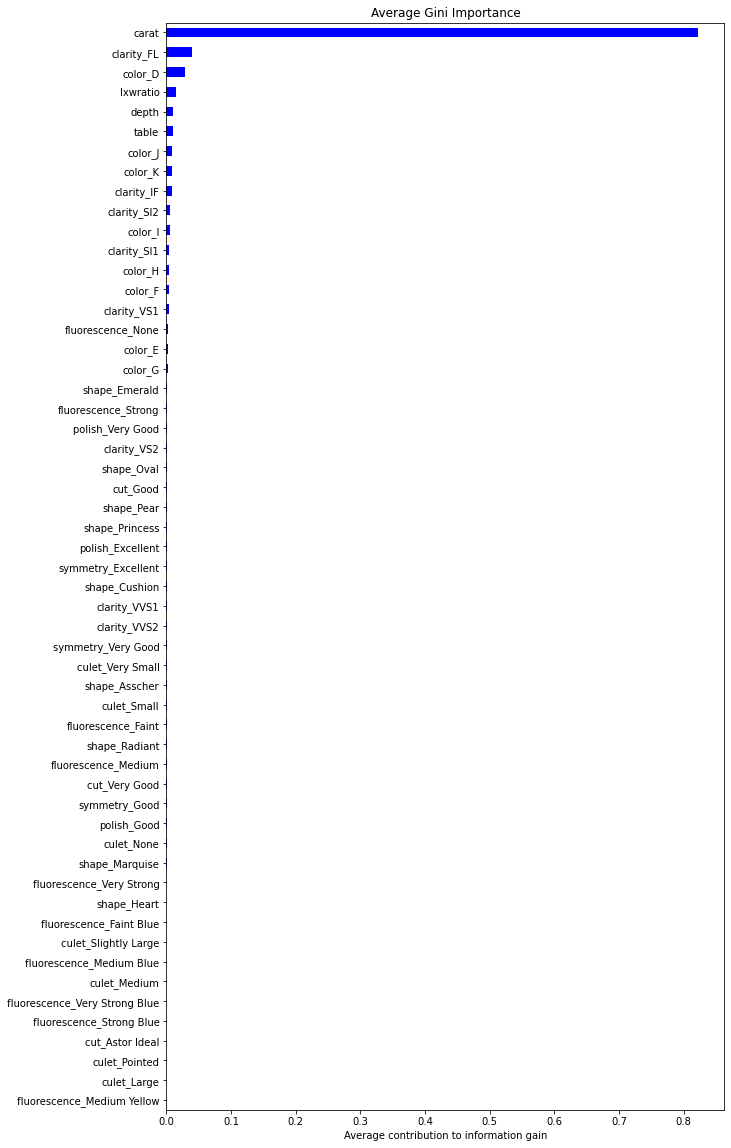

In [974]:
# Plot the feature importance
feat_scores = pd.Series(rf.feature_importances_,
                           index=X_train_1.columns)
feat_scores = feat_scores.sort_values()
ax = feat_scores.plot(kind='barh', 
                      figsize=(10,20),
                      color='b')
ax.set_title('Average Gini Importance')
ax.set_xlabel('Average contribution to information gain');

* n_estimators = number of trees in the foreset
* max_features = max number of features considered for splitting a node
* max_depth = max number of levels in each decision tree
* min_samples_split = min number of data points placed in a node before the node is split
* min_samples_leaf = min number of data points allowed in a leaf node
* bootstrap = method for sampling data points (with or without replacement)

In [1063]:
#creating a random grid
n_estimators = [int(x) for x in np.linspace(start=200,stop=500, num =4)]
max_features = ['auto','sqrt']
min_samples_split = [2,5,10]
min_samples_leaf = [1,2,4]

random_grid = {'n_estimators': n_estimators, 
               'max_features': max_features,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}

In [1064]:
rf = RandomForestRegressor(max_depth = 20, n_jobs = -1 )
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 50, cv=3,n_jobs=-1)
rf_random.fit(X_train_1,y_train)

RandomizedSearchCV(cv=3,
                   estimator=RandomForestRegressor(max_depth=20, n_jobs=-1),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 300, 400, 500]})

In [1065]:
rf_random.best_params_

{'n_estimators': 300,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'auto'}

In [1017]:
rf = RandomForestRegressor(n_estimators = 250, min_samples_split =2, min_samples_leaf = 1, max_features = 'auto', max_depth = 100).fit(X_train_1,y_train)
print(f'Train RMSE: {-cross_val_score(rf,X_train_1,y_train, scoring="neg_root_mean_squared_error").mean()}')
print(f'Test RMSE: {np.sqrt(mean_squared_error(y_test,rf.predict(X_test_1)))}')

Train RMSE: 7106.194162864938
Test RMSE: 18698.54514056478


A Random Forest Regressor with 1 # trees gets a score of 11176.095897196257
A Random Forest Regressor with 5 # trees gets a score of 8552.025555891069
A Random Forest Regressor with 10 # trees gets a score of 7412.964709538256
A Random Forest Regressor with 20 # trees gets a score of 7510.149420683639
A Random Forest Regressor with 50 # trees gets a score of 7076.474429446709
A Random Forest Regressor with 100 # trees gets a score of 7110.977498026284
A Random Forest Regressor with 200 # trees gets a score of 7030.275635041355
A Random Forest Regressor with 500 # trees gets a score of 7071.017200483923
A Random Forest Regressor with 1000 # trees gets a score of 7053.021918440689


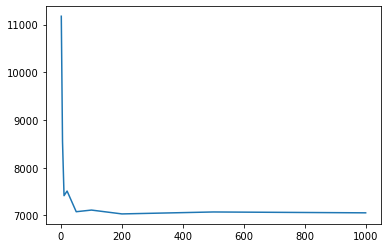

In [1042]:
trees = [1, 5, 10, 20, 50, 100, 200, 500, 1000]
scores = []

for t in trees:
    model = RandomForestRegressor(n_estimators=t, n_jobs = -1)
    score = -cross_val_score(model,X_train_1,y_train, scoring="neg_root_mean_squared_error").mean()
    print('A Random Forest Regressor with {} # trees gets a score of {}'
          .format(t,score))
    scores.append(score)

fig, ax = plt.subplots()
ax.plot(trees, scores)

In [1048]:
depth = [1, 5, 10, 20, 50, 100]
scores = []
for d in depth:
    model = RandomForestRegressor(max_depth=d, n_jobs = -1)
    score = -cross_val_score(model,X_train_1,y_train, scoring="neg_root_mean_squared_error").mean()
    print('A Random Forest Regressor with max_depth of: {} gets a score of {}'
          .format(d,score))
    scores.append(score)

A Random Forest Regressor with max_depth of: 1 gets a score of 17415.272001701796
A Random Forest Regressor with max_depth of: 5 gets a score of 8860.923002807176
A Random Forest Regressor with max_depth of: 10 gets a score of 7477.358983369717
A Random Forest Regressor with max_depth of: 20 gets a score of 7001.749641253237
A Random Forest Regressor with max_depth of: 50 gets a score of 7174.962332790188
A Random Forest Regressor with max_depth of: 100 gets a score of 7005.565785643569


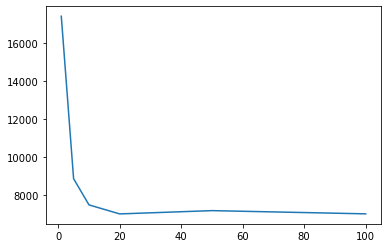

In [1049]:
fig, ax = plt.subplots()
ax.plot(depth, scores)

In [1055]:
df.sort_values('original_price', ascending=False)[:50]

,shape,original_price,carat,cut,color,clarity,polish,symmetry,fluorescence,depth,table,lxwratio,culet,log_price
52885,Emerald,2702260,20.03,Very Good,D,IF,Very Good,Very Good,None,60.4,65.0,1.18,Medium,14.809599
52884,Pear,1244433,10.51,Very Good,D,FL,Excellent,Excellent,None,62.0,56.0,1.55,None,14.034191
52883,Pear,1030445,9.52,Very Good,D,FL,Excellent,Very Good,None,62.3,56.0,1.63,None,13.845501
52882,Princess,930395,15.06,Very Good,F,VS1,Excellent,Excellent,None,73.7,71.0,1.03,None,13.743365
52881,Pear,882083,10.88,Very Good,D,FL,Excellent,Excellent,Faint,60.9,63.0,1.61,None,13.690041
52880,Pear,786746,15.01,Very Good,E,SI1,Very Good,Very Good,Faint Blue,64.0,62.0,1.69,None,13.575661
52879,Emerald,786602,9.31,Very Good,D,FL,Excellent,Excellent,None,60.9,61.0,1.46,None,13.575478
52878,Pear,765958,7.60,Very Good,D,IF,Excellent,Excellent,None,58.8,58.0,1.47,None,13.548883
52877,Pear,761028,10.81,Very Good,D,VVS2,Very Good,Very Good,None,61.7,52.0,1.55,Small,13.542425
52876,Emerald,742473,10.06,Very Good,D,VS2,Excellent,Excellent,None,67.1,64.0,1.40,None,13.517742
